# 作业

In [2]:
import numpy as np 
from scipy.special import softmax 
from scipy.stats import bernoulli, norm, uniform
import time 
from scipy.optimize import minimize
from ddm import ddmpdf, pdf # ddm probility density function

from IPython.display import clear_output
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt 
import seaborn as sns 

import sys 
sys.path.append("..") 
from utils.env import frozen_lake
from utils.viz import viz 
viz.get_style()

In [3]:
# load  data
data = np.loadtxt('example.txt')
nTrial = data.shape[0] # how many trials
eps = np.finfo(float).eps

###

**Q1.1: 请写出ddm的负对数似然函数`negloglikeli`(negative log-likelihood function)**


In [4]:
# define a negative log-likelihood objective functions
def negloglikeli(params, data):
    '''
    <params>:(4,) array, drift coefficient, decision boundary, initial bias, non-decision time
    '''
    k = params[0] # drift coefficient
    B = params[1] # decision boundary
    a = params[2] # initial bias (0, 1)
    ndt = params[3] # non-decision time
    
    nTrial = data.shape[0] # how many trials
    pp = np.empty(nTrial)
    for i in range(nTrial): # loop trial
        pp[i] = ddmpdf(k, a, B, ndt, coh=data[i, 0], rt=data[i, 1], correct=data[i, 2])

    pp_valid = np.maximum(pp, 1e-15)  # Set a small positive threshold for invalid probabilities
    return -np.log(pp_valid).sum() # take log, sum，add negative

###

**Q1.2: 利用最大似然估计(maximum likelihood estimation)的方法求解ddm模型参数k,b.a,ndt**

参数k,b.a,ndt的bounds分别为((0, 20), (0, 5), (0, 1), (0, 1))


In [6]:
np.random.seed(1234)
res = minimize(fun=negloglikeli, x0=(1.6, 2.3, 0.5, 0.01), args=(data),bounds=((0, 20), (0, 5), (0, 1), (0, 1)))

print('\nfitted drift coefficient is ', res.x[0])
print('fitted decision boundary is ', res.x[1])
print('fitted initial bias is ', res.x[2])
print('fitted nondecision time is ', res.x[3])


fitted drift coefficient is  1.0311682099419661
fitted decision boundary is  2.3827290342577285
fitted initial bias is  0.4972358161521576
fitted nondecision time is  0.20728465380894037


###
**Q2: 利用Metropolitan-Hasting的方法求解DDM模型参数.不能借助工具包，必须手写M-H**


In [8]:
# define a negative log-likelihood objective functions
def loglikeli(k, data):
    '''
    <params>:(4,) array, drift coefficient, decision boundary, initial bias, non-decision time
    '''
    B = 2 # decision boundary
    a = 0.5# initial bias (0, 1)
    ndt = 0.1 # non-decision time
    nTrial = data.shape[0] # how many trials
    pp = np.empty(nTrial)
    for i in range(nTrial): # loop trial
        pp[i] = ddmpdf(k, a, B, ndt, coh=data[i, 0], rt=data[i, 1], correct=data[i, 2])

    pp_valid = 0.99*pp+eps  # Set a small positive threshold for invalid probabilities
    return np.log(pp_valid).sum() # take log, sum，add negative

In [9]:
#proposal dist 为gamma分布.使得drift coefficient始终大于零
def metropolis_hastings(data, y_k, n_sample=3000, n_burnin=1000, random_seed=1234):
    np.random.seed(random_seed)
    samples = []
    init_k = y_k  # 初始化你要估计的参数

    for i in range(n_sample + n_burnin):
        # 从提议分布中采样
        pro_k = np.exp(norm(loc=init_k,).rvs())
        # 由于k始终大于零，所以需要进行指数函数的转换
        
        # 计算对数似然
        loglik_proposed = loglikeli(pro_k, data)
        loglik_init = loglikeli(init_k, data)
        
        # 计算接受率
        a_log = np.min([0, (loglik_proposed-loglik_init)])
        # 接受或拒绝 
        u_log = np.log(uniform.rvs(0,1))
        if u_log < a_log:
            samples.append(pro_k)   # 接受并跳转到新的sample
            init_k = pro_k
        else:samples.append(init_k) # 保留原来那个sample不变
    return samples

# 设置初始参数值
y_k = 0.1

# 调用 Metropolis-Hastings 算法
samples = metropolis_hastings(data, y_k)


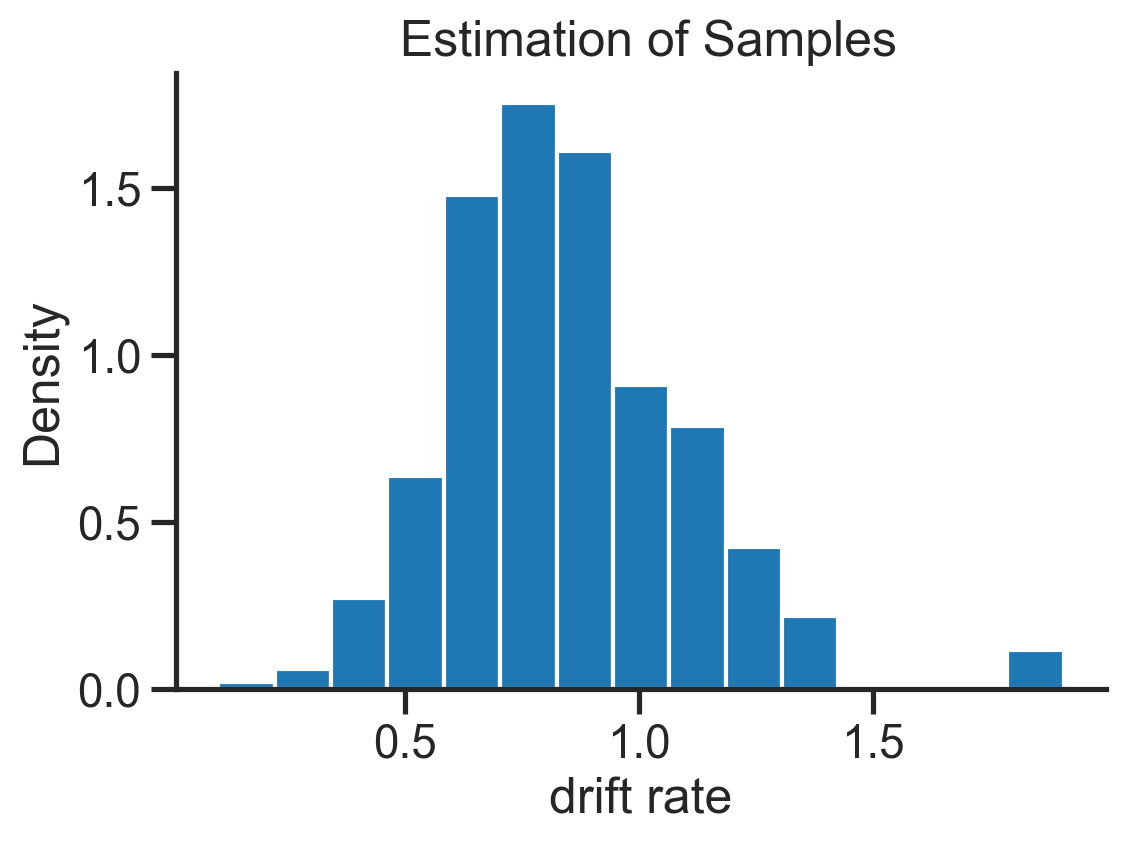

In [23]:
import matplotlib.pyplot as plt
# 绘制核密度估计图
plt.figure(figsize = (6,4))
plt.hist(samples, bins=15, density=True, label='samples')
plt.xlabel('drift rate')
plt.ylabel('Density')
plt.title(' Estimation of Samples')
plt.savefig('MH.png')
plt.show()


###
**Q3：value iteration。**

In [ ]:
seed = 1234
env = frozen_lake(seed=seed)
env.reset()
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
env.render(ax)

In [ ]:
def value_iter(env, seed=1234, theta=1e-4, gamma=.99, show_update=False):
    
    rng = np.random.RandomState(seed)
    # initialize V(s), arbitrarily except V(terminal)=0
    V = rng.rand(env.nS) * 0.001
    # except v(terminal) = 0
    for s in env.s_termination:
        V[s] = 0
    # init policy 
    pi = np.zeros([env.nS, env.nA])
    # loop until converge
    while True:
        delta = 0
        for s in env.S:
            v_old = V[s].copy()
            q = np.zeros([env.nA])
            for a in env.A:
                p = env.p_s_next(s, a)
                for s_next in env.S:
                    r, done = env.r(s_next)
                    q[a] += p[s_next]*(r + (1-done)*gamma*V[s_next])
            V[s] = np.max(q)
            pi[s] = np.eye(env.nA)[np.argmax(q)]
            delta = np.max([delta, np.abs(V[s] - v_old)])

        # visualize 
        if show_update:
            _, axs = plt.subplots(1, 2, figsize=(8, 4))
            clear_output(True)
            ax = axs[0]
            env.show_v(ax, V)
            ax = axs[1]
            env.show_pi(ax, pi)
            time.sleep(.1)
            plt.show()

        # check convergence
        if delta < theta: break 

    for s in env.s_termination:
        V[s] = 0
    return V, pi 
        

In [ ]:
# 可视化
V2, pi2 = value_iter(env)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[0]
env.show_v(ax, V2)
ax = axs[1]
env.show_pi(ax, pi2)
plt.savefig('value_and_policy.png')  # 将图像保存为 PNG 格式

plt.show()

### 
**Q4.2：补充sarsa 代码**

In [ ]:
def e_greedy(q, rng, env, eps):
    a_max = np.argwhere(q==np.max(q)).flatten()
    policy = np.sum([np.eye(env.nA)[i] for i in a_max], axis=0) / len(a_max)
    if rng.rand() < 1-eps:
        a = rng.choice(env.nA, p=policy)
    else:
        a = rng.choice(env.nA)
    return a 

In [ ]:
def Sarsa(env, alpha=.2, eps=.1, gamma=.99, max_epi=5000, seed=1234, theta=1e-4):
    # rng
    rng = np.random.RandomState(seed)
    # initialize Q
    Q = np.zeros([env.nS, env.nA])
    for _ in range(max_epi):
        G = 0
        q_old = Q.copy()
        s, _, done = env.reset()
        # sample At, observe Rt, St+1
        a = e_greedy(Q[s, :], rng, env, eps)
        while True:
            s_next, r, done = env.step(a)
            a_next = e_greedy(Q[s_next, :], rng, env, eps)
            Q_tar  = r + (1-done)*gamma*(Q[s_next, a_next])  # 根据Sarsa更新目标Q值
            Q[s,a] += alpha*(Q_tar-Q[s,a])  # 更新Q值
            s = s_next
            a = a_next
            G += r
            if done:
                break 
        delta = np.max(np.abs(q_old - Q))
        if (delta < theta).all():
            break
    pi = np.eye(env.nA)[np.argmax(Q, axis=1)]
    return Q, pi

In [ ]:
## 可视化
Q_sarsa, pi_sarsa = Sarsa(env)
V3 = Q_sarsa.max(1)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[0]
env.show_v(ax, V3)
ax = axs[1]
env.show_pi(ax, pi_sarsa)
plt.savefig('sarsa.png')

plt.show()